# Build your own NSFW Image Detector with Tensorflow

## Intro

In the age of the internet, the abundance of content also means an influx of potentially explicit or NSFW (Not Safe for Work) material. Detecting and filtering such content has become a pressing necessity for platforms and individuals alike. In this blog post, we'll explore how to create an NSFW image detector using TensorFlow and Python. TensorFlow, a powerful machine learning framework, will be our tool of choice for this task, offering flexibility and scalability.

By the end of this guide, you'll have not only a functioning NSFW image detector but also a solid understanding of how deep learning models work and how to apply them to real-world issues. Whether you're a platform administrator striving to maintain a safe environment or someone eager to delve into the world of machine learning, join us on this journey to enhance online safety and security.

## Prerequisites

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


## Create train dataset

In [2]:
data_dir = os.path.join(os.getcwd(),'images')

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11178 files belonging to 5 classes.
Using 8943 files for training.


## Create validation dataset

In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11178 files belonging to 5 classes.
Using 2235 files for validation.


## Create test dataset

In [4]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [5]:
class_names = train_ds.class_names
print(class_names)

['drawings', 'hentai', 'neutral', 'porn', 'sexy']


In [8]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create basic model

In [8]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [11]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


280/280 [==============================] - 195s 509ms/step - loss: 1.3037 - accuracy: 0.4560 - val_loss: 1.0736 - val_accuracy: 0.5574
Epoch 2/10
280/280 [==============================] - 133s 474ms/step - loss: 0.9335 - accuracy: 0.6386 - val_loss: 0.9959 - val_accuracy: 0.5988
Epoch 3/10
280/280 [==============================] - 136s 487ms/step - loss: 0.7738 - accuracy: 0.7017 - val_loss: 0.8836 - val_accuracy: 0.6542
Epoch 4/10
280/280 [==============================] - 136s 486ms/step - loss: 0.6000 - accuracy: 0.7730 - val_loss: 0.9185 - val_accuracy: 0.6469
Epoch 5/10
280/280 [==============================] - 133s 475ms/step - loss: 0.3987 - accuracy: 0.8571 - val_loss: 1.0367 - val_accuracy: 0.6447
Epoch 6/10
280/280 [==============================] - 121s 433ms/step - loss: 0.2133 - accuracy: 0.9288 - val_loss: 1.2735 - val_accuracy: 0.6530
Epoch 7/10
280/280 [==============================] - 122s 434ms/step - loss: 0.0998 - accuracy: 0.9725 - val_loss: 1.6632 - val_accura

## Visualize training results

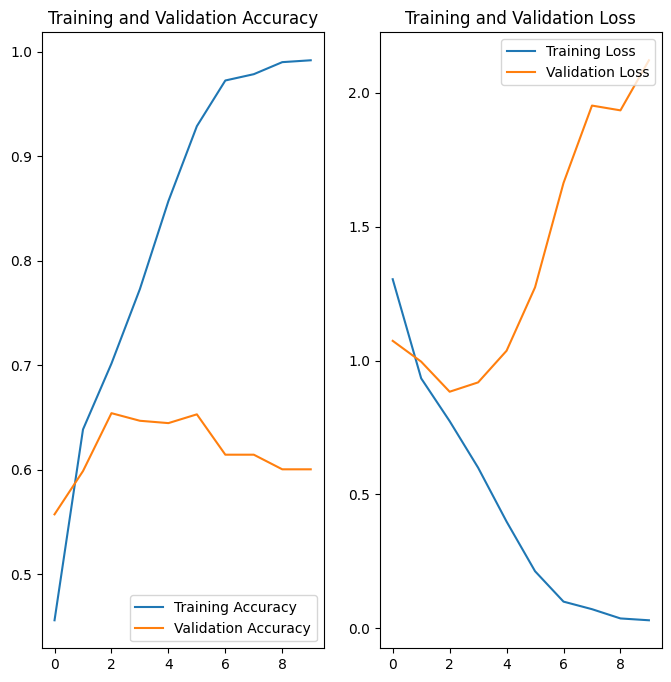

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

14/14 [==============================] - 6s 275ms/step - loss: 2.1036 - accuracy: 0.5893
Test accuracy : 0.5892857313156128


In [14]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)
y_test = list(map(lambda x: class_names[x],y_test))

In [15]:
y_prob = model.predict(test_ds)
y_pred = y_prob.argmax(axis=1)
y_pred = list(map(lambda x: class_names[x],y_pred))

14/14 [==============================] - 1s 100ms/step


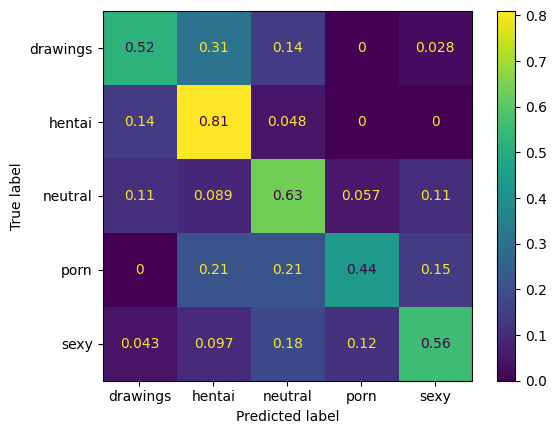

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize = 'true')

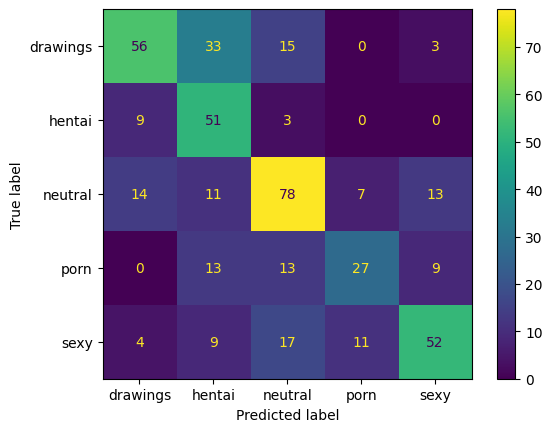

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

## Data Augmentation

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [22]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

## Layer Dropout

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

# Compile and train

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
280/280 [==============================] - 134s 473ms/step - loss: 1.2473 - accuracy: 0.4800 - val_loss: 1.3335 - val_accuracy: 0.4594
Epoch 2/20
280/280 [==============================] - 132s 472ms/step - loss: 1.0482 - accuracy: 0.5807 - val_loss: 1.4870 - val_accuracy: 0.5048
Epoch 3/20
280/280 [==============================] - 133s 476ms/step - loss: 0.9800 - accuracy: 0.6121 - val_loss: 1.0662 - val_accuracy: 0.6010
Epoch 4/20
280/280 [==============================] - 133s 474ms/step - loss: 0.9298 - accuracy: 0.6250 - val_loss: 1.6122 - val_accuracy: 0.4566
Epoch 5/20
280/280 [==============================] - 133s 474ms/step - loss: 0.8806 - accuracy: 0.6526 - val_loss: 1.2709 - val_accuracy: 0.5697
Epoch 6/20
280/280 [==============================] - 133s 475ms/step - loss: 0.8587 - accuracy: 0.6576 - val_loss: 1.1400 - val_accuracy: 0.6021
Epoch 7/20
280/280 [==============================] - 133s 476ms/step - loss: 0.8068 - accuracy: 0.6800 - val_loss: 1.0607 -

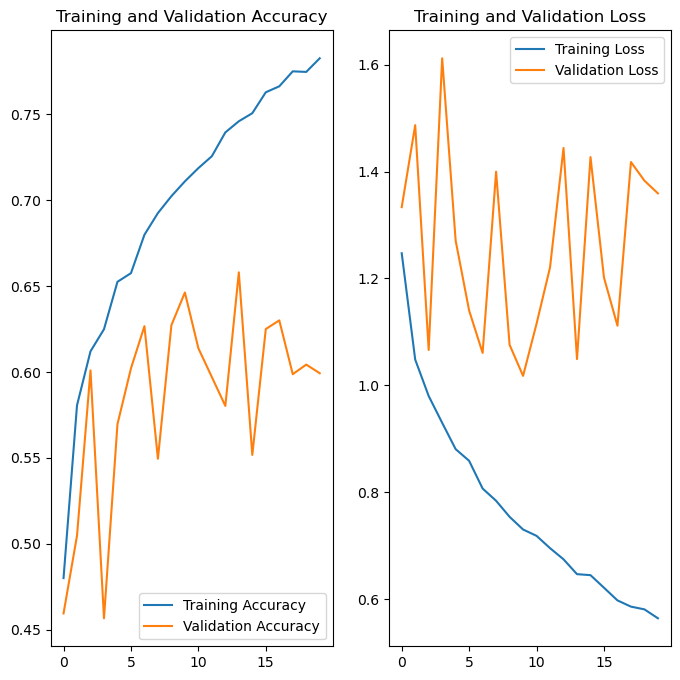

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

14/14 [==============================] - 1s 103ms/step - loss: 1.2539 - accuracy: 0.5960
Test accuracy : 0.5959821343421936


In [29]:
y_prob = model.predict(test_ds)
y_pred = y_prob.argmax(axis=1)
y_pred = list(map(lambda x: class_names[x],y_pred))

14/14 [==============================] - 1s 101ms/step


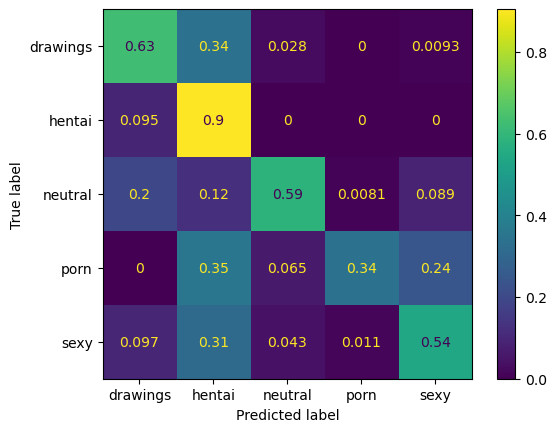

In [30]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize = 'true')

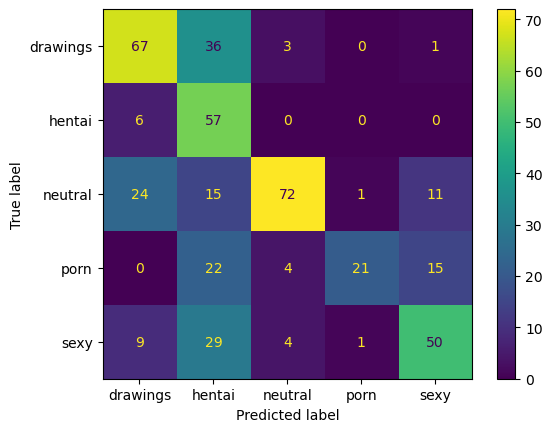

In [31]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

# Transfer Learning

In [20]:
IMG_SHAPE = (img_height, img_width)+(3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [21]:
base_model.trainable = False

In [22]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 90, 90, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 90, 90, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 90, 90, 32)           0         ['bn_Conv1[

In [23]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

In [24]:
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [25]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [26]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [27]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 180, 180, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                             

In [29]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

56/56 [==============================] - 26s 437ms/step - loss: 2.5137 - accuracy: 0.1729


In [31]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.51
initial accuracy: 0.17


In [32]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


280/280 [==============================] - 164s 576ms/step - loss: 1.5891 - accuracy: 0.3725 - val_loss: 0.9647 - val_accuracy: 0.6200
Epoch 2/10
280/280 [==============================] - 168s 600ms/step - loss: 0.9818 - accuracy: 0.6209 - val_loss: 0.7162 - val_accuracy: 0.7342
Epoch 3/10
280/280 [==============================] - 167s 597ms/step - loss: 0.7954 - accuracy: 0.6976 - val_loss: 0.6358 - val_accuracy: 0.7627
Epoch 4/10
280/280 [==============================] - 173s 619ms/step - loss: 0.7175 - accuracy: 0.7349 - val_loss: 0.5968 - val_accuracy: 0.7795
Epoch 5/10
280/280 [==============================] - 185s 661ms/step - loss: 0.6711 - accuracy: 0.7444 - val_loss: 0.5781 - val_accuracy: 0.7890
Epoch 6/10
280/280 [==============================] - 187s 667ms/step - loss: 0.6498 - accuracy: 0.7606 - val_loss: 0.5545 - val_accuracy: 0.7924
Epoch 7/10
280/280 [==============================] - 186s 665ms/step - loss: 0.6228 - accuracy: 0.7665 - val_loss: 0.5520 - val_accura

In [35]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

14/14 [==============================] - 6s 401ms/step - loss: 0.4913 - accuracy: 0.8214
Test accuracy : 0.8214285969734192


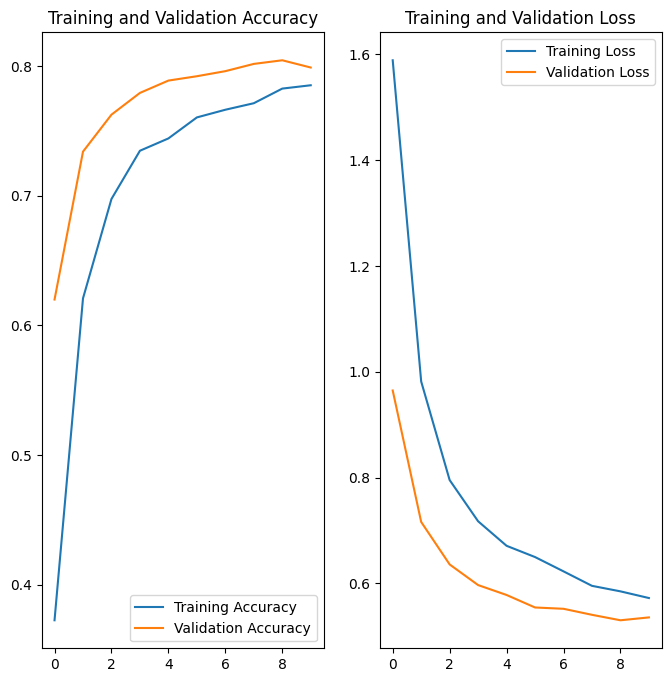

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
y_prob = model.predict(test_ds)
y_pred = y_prob.argmax(axis=1)
y_pred = list(map(lambda x: class_names[x],y_pred))

14/14 [==============================] - 7s 425ms/step


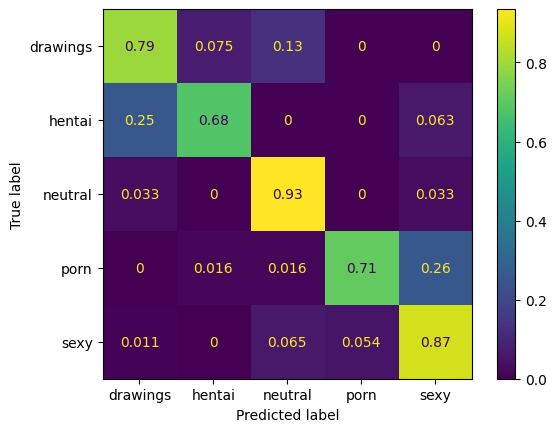

In [38]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize = 'true')

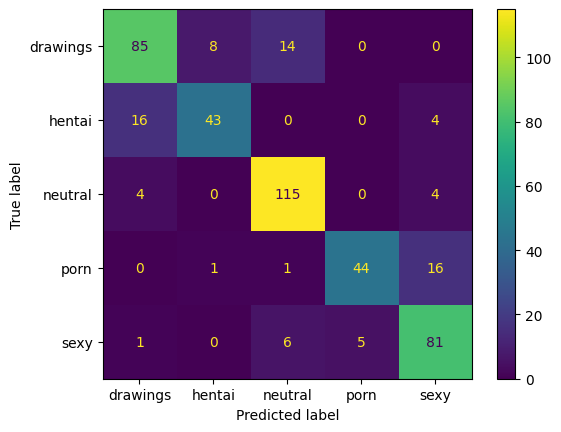

In [39]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

# Fine Tuning

In [51]:
base_model.trainable = True

In [52]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [53]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 180, 180, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                             

In [55]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20


280/280 [==============================] - 234s 816ms/step - loss: 0.5367 - accuracy: 0.8011 - val_loss: 0.4692 - val_accuracy: 0.8293
Epoch 11/20
280/280 [==============================] - 226s 809ms/step - loss: 0.4619 - accuracy: 0.8239 - val_loss: 0.4432 - val_accuracy: 0.8360
Epoch 12/20
280/280 [==============================] - 226s 808ms/step - loss: 0.4368 - accuracy: 0.8329 - val_loss: 0.4455 - val_accuracy: 0.8327
Epoch 13/20
280/280 [==============================] - 228s 814ms/step - loss: 0.3955 - accuracy: 0.8525 - val_loss: 0.4266 - val_accuracy: 0.8422
Epoch 14/20
280/280 [==============================] - 267s 955ms/step - loss: 0.3810 - accuracy: 0.8564 - val_loss: 0.4143 - val_accuracy: 0.8511
Epoch 15/20
280/280 [==============================] - 288s 1s/step - loss: 0.3507 - accuracy: 0.8669 - val_loss: 0.4132 - val_accuracy: 0.8433
Epoch 16/20
280/280 [==============================] - 246s 879ms/step - loss: 0.3312 - accuracy: 0.8754 - val_loss: 0.4006 - val_acc

In [56]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

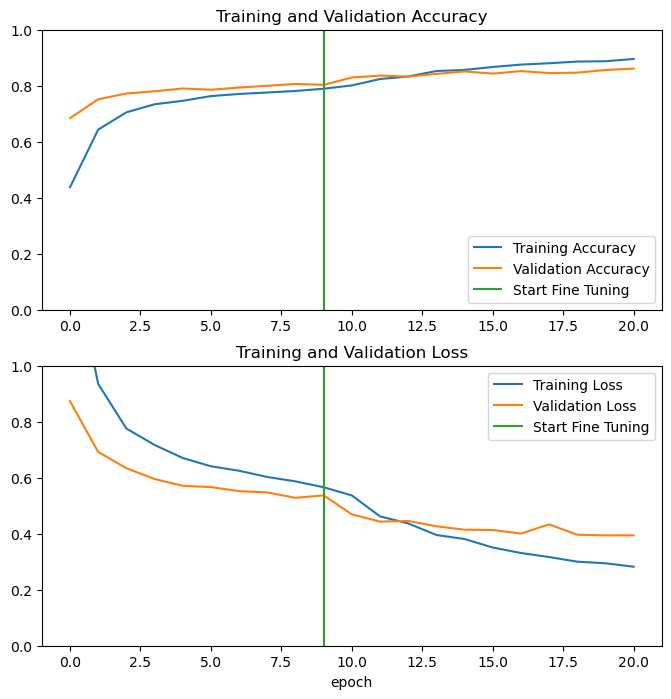

In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

14/14 [==============================] - 7s 463ms/step - loss: 0.3555 - accuracy: 0.8705
Test accuracy : 0.8705357313156128


In [59]:
y_prob= model.predict(test_ds)
y_pred = y_prob.argmax(axis=1)
y_pred = list(map(lambda x: class_names[x],y_pred))

14/14 [==============================] - 8s 473ms/step


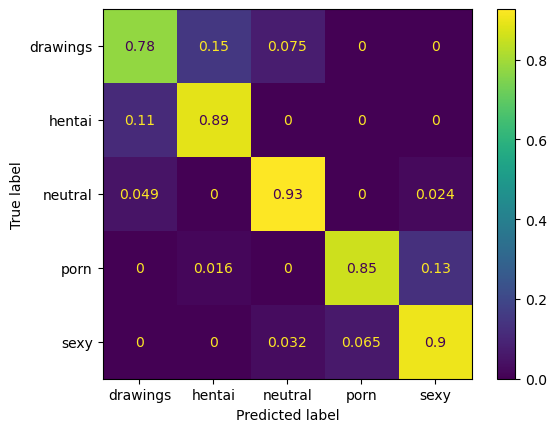

In [60]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize = 'true')

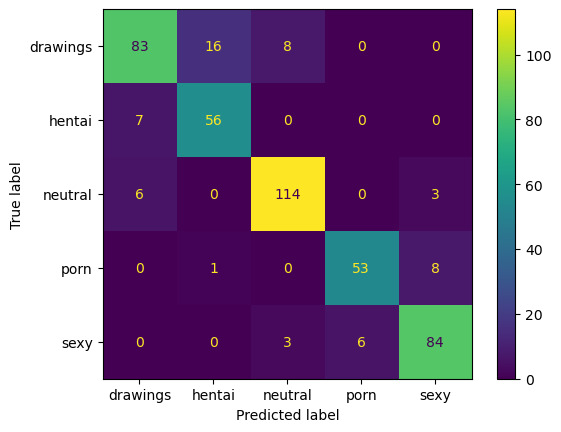

In [61]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)